<a href="https://colab.research.google.com/github/AayanHidol/NNZH-by-Andrej-Karpathy/blob/main/The_spelled_out_intro_to_neural_networks_and_backpropagation_building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [209]:
def f(x):
  return 3*x**2 - 4*x + 5


In [210]:
f(3.0)

20.0

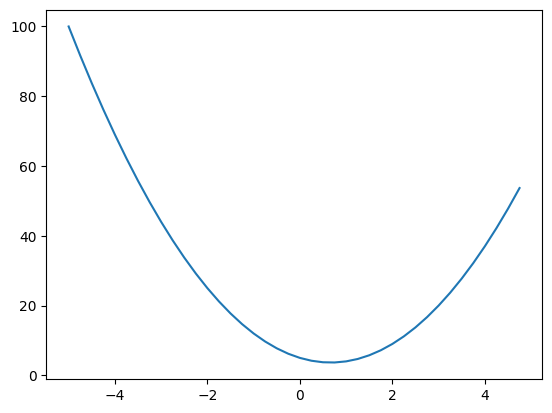

In [211]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [212]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [213]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [214]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [215]:
### is syntax ka ghanta kuch samajh nahi aa raha 🥲

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # at initialization it is 0,
    self._backward = lambda: None
    self._prev = set(_children) ## check this on chatgpt
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1- t**2) * out.grad
    out._backward = _backward

    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = [] ### See topographical sort
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [216]:

a = Value(2.0)
b = Value(4.0)
2 * a # this still doesn't work because pthon calls

1 + a

a.exp()

a/b

Value(data=0.5)

In [217]:
# a/b = a * (1/b) = a * (b**-1)

#

In [218]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
#(a.__mul__(b)).__add__(c)

In [219]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [220]:
d._op

'+'

In [221]:
from graphviz import Digraph ## check Graphviz software

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph , create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

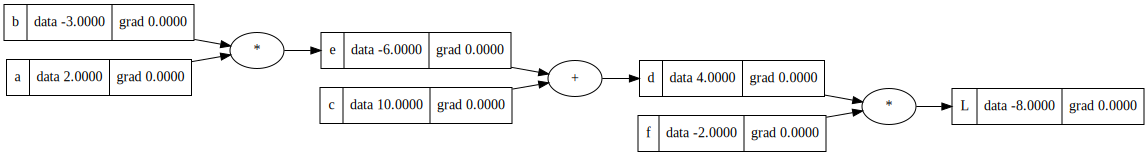

In [222]:
draw_dot(L)

In [223]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [224]:
a.grad = 6.0
b.grad = -4.0

dL/de = -2.0

e = a * b

de/da = b;
de/db = a

* dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0

* dL/db = dL/de * de/db = -2.0 * 2.0 = -4.0

L = d * f

dL/dd = f

(f(x+h) - f(x)) / h


In [225]:
f.grad = 4.0
d.grad = -2.0

In [226]:
L.grad = 1.0

dL/dc = dL/dd * dd/dc = f * 1.0    
*# chain rule XD!*

* dL/dd = f

* d = c + e
* dd/dc = 1.0
* dd/de = 1.0

In [227]:
c.grad = -2.0
e.grad = -2.0

In [228]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


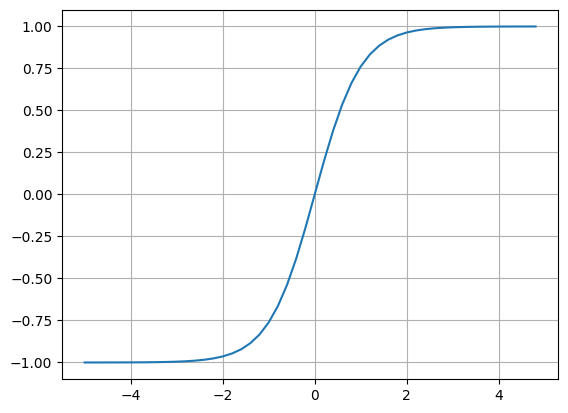

In [229]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [230]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

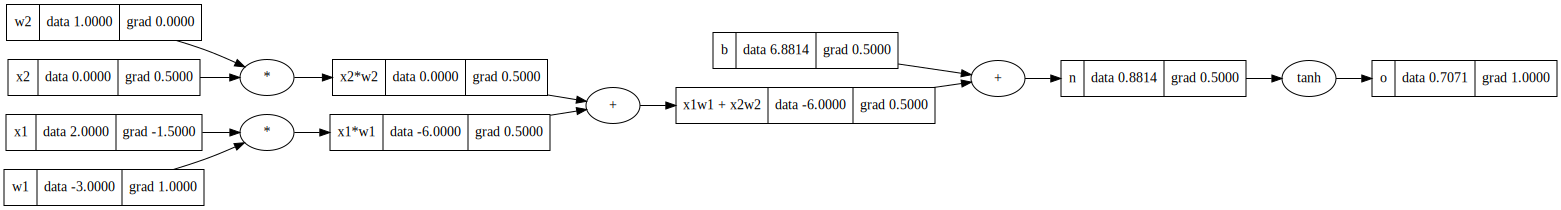

In [231]:
draw_dot(o)

In [232]:
o.backward()

In [233]:
topo = [] ### See topographical sort
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [234]:
o.grad = 1.0
o._backward()

In [235]:
n._backward()

In [236]:
b._backward()

In [237]:
x1w1x2w2._backward()

In [238]:
x2w2._backward()
x1w1._backward()

In [239]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [240]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [241]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [242]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [243]:
n.grad = 0.5

In [244]:
o.grad = 1.0

In [245]:
1 - o.data**2

0.4999999999999999

In [246]:
# o = tanh(n)
# do/dn = 1 - o**2

### There is a bug in our code, which has been corrected by accumulating / depositing the gradients (by changing = to +=), so the code below looks okay 😂

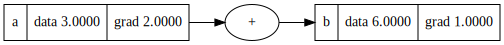

In [247]:
 # db/da = 2, but because we are calling our function twice, once on self, and then on other it overwrides it
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

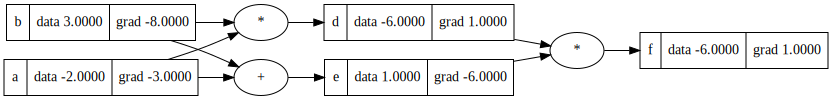

In [248]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

In [249]:
# The bug happens when we use the variable more than once, which results in overwriding of the original one

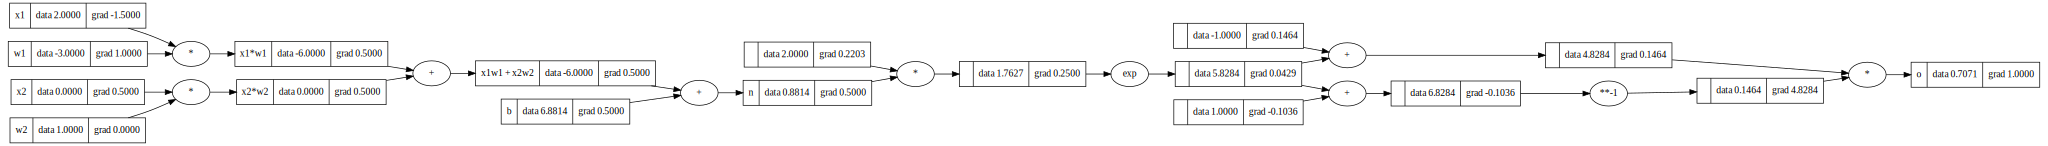

In [251]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------

o.label = 'o'

o.backward()

draw_dot(o)

## Doing the same thing as above using PyTorch

In [253]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


* `double()` casts the default PyTorch `dtype = torch.float32` to `torch.float64` because python used double floating point precision

* `requires_grad() = True` ensures that PyTorch calculates the gradients for the leaf nodes which by default is off

In [257]:
import random

In [439]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [440]:
len(n.parameters())

41

In [441]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4,  1])
n(x)

Value(data=0.37925143375015163)

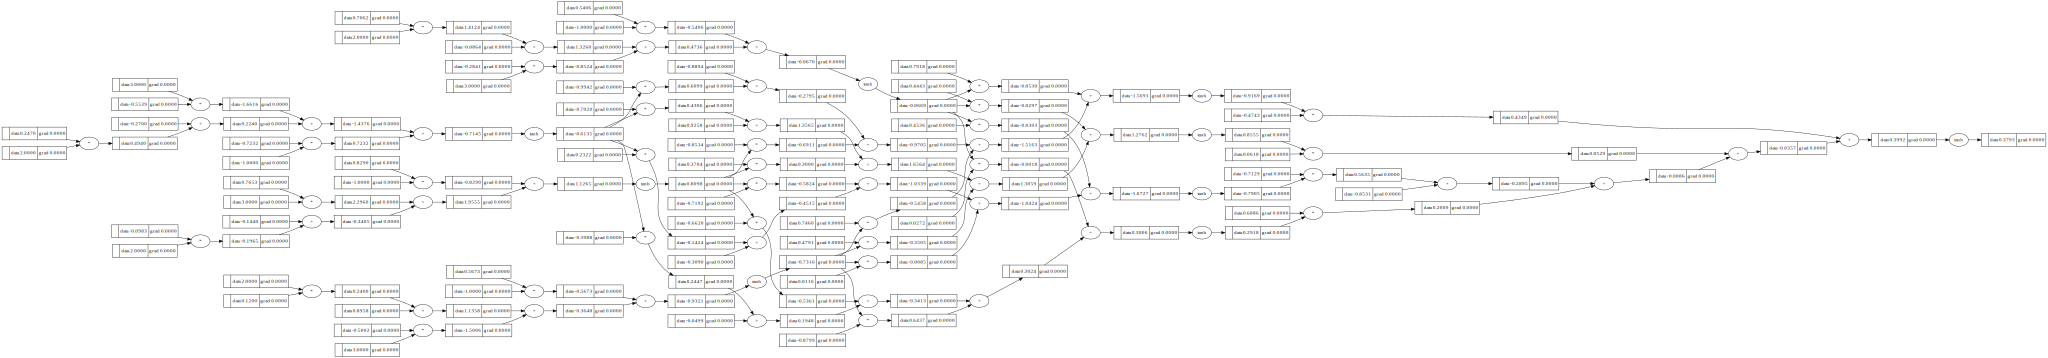

In [442]:
draw_dot(n(x))


In [443]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.37925143375015163),
 Value(data=-0.9575436617323986),
 Value(data=-0.7026050434997367),
 Value(data=-0.2597108419764443)]

In [461]:
for k in range(2000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  #print(k, loss.data)

In [462]:
ypred

[Value(data=0.9951493639177391),
 Value(data=-0.9980250271757595),
 Value(data=-0.9942386052154267),
 Value(data=0.9937892670782416)]

In [457]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0061980378732645405)

In [425]:
loss.backward()

In [426]:
n.layers[0].neurons[0].w[0].grad

8.54353544652575

In [427]:
n.layers[0].neurons[0].w[0].data

-2.347759539739274

In [428]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [429]:
ypred

[Value(data=0.9938486116024369),
 Value(data=-0.9996950320744222),
 Value(data=-0.9997024926981635),
 Value(data=0.9938635716227409)]

In [430]:
n.parameters()

[Value(data=-2.4331948942045316),
 Value(data=-0.0650704214286437),
 Value(data=-0.38206596715904073),
 Value(data=-0.713308952702757),
 Value(data=0.24002787967904765),
 Value(data=-1.1279410560944119),
 Value(data=-0.4494769247302213),
 Value(data=-0.38392136829505036),
 Value(data=-0.1930375919571089),
 Value(data=0.32134950426490455),
 Value(data=-0.8511144656333905),
 Value(data=-0.22954582018732334),
 Value(data=-0.4343122076016736),
 Value(data=0.1577597834518477),
 Value(data=-2.0019691145847682),
 Value(data=-0.6861037825670582),
 Value(data=-0.2702528550958167),
 Value(data=0.960802759109948),
 Value(data=2.252489925723037),
 Value(data=2.0973843504734315),
 Value(data=0.4117599146891068),
 Value(data=0.1061836485053577),
 Value(data=-0.9825974747699826),
 Value(data=1.460631543849427),
 Value(data=2.6510997686636006),
 Value(data=0.5446123454884043),
 Value(data=0.8195186523241482),
 Value(data=-0.005200350015606252),
 Value(data=0.9394738860709382),
 Value(data=0.6333745079

In [411]:
n.layers[0].neurons[0].w[0].data

-2.1768888317946753

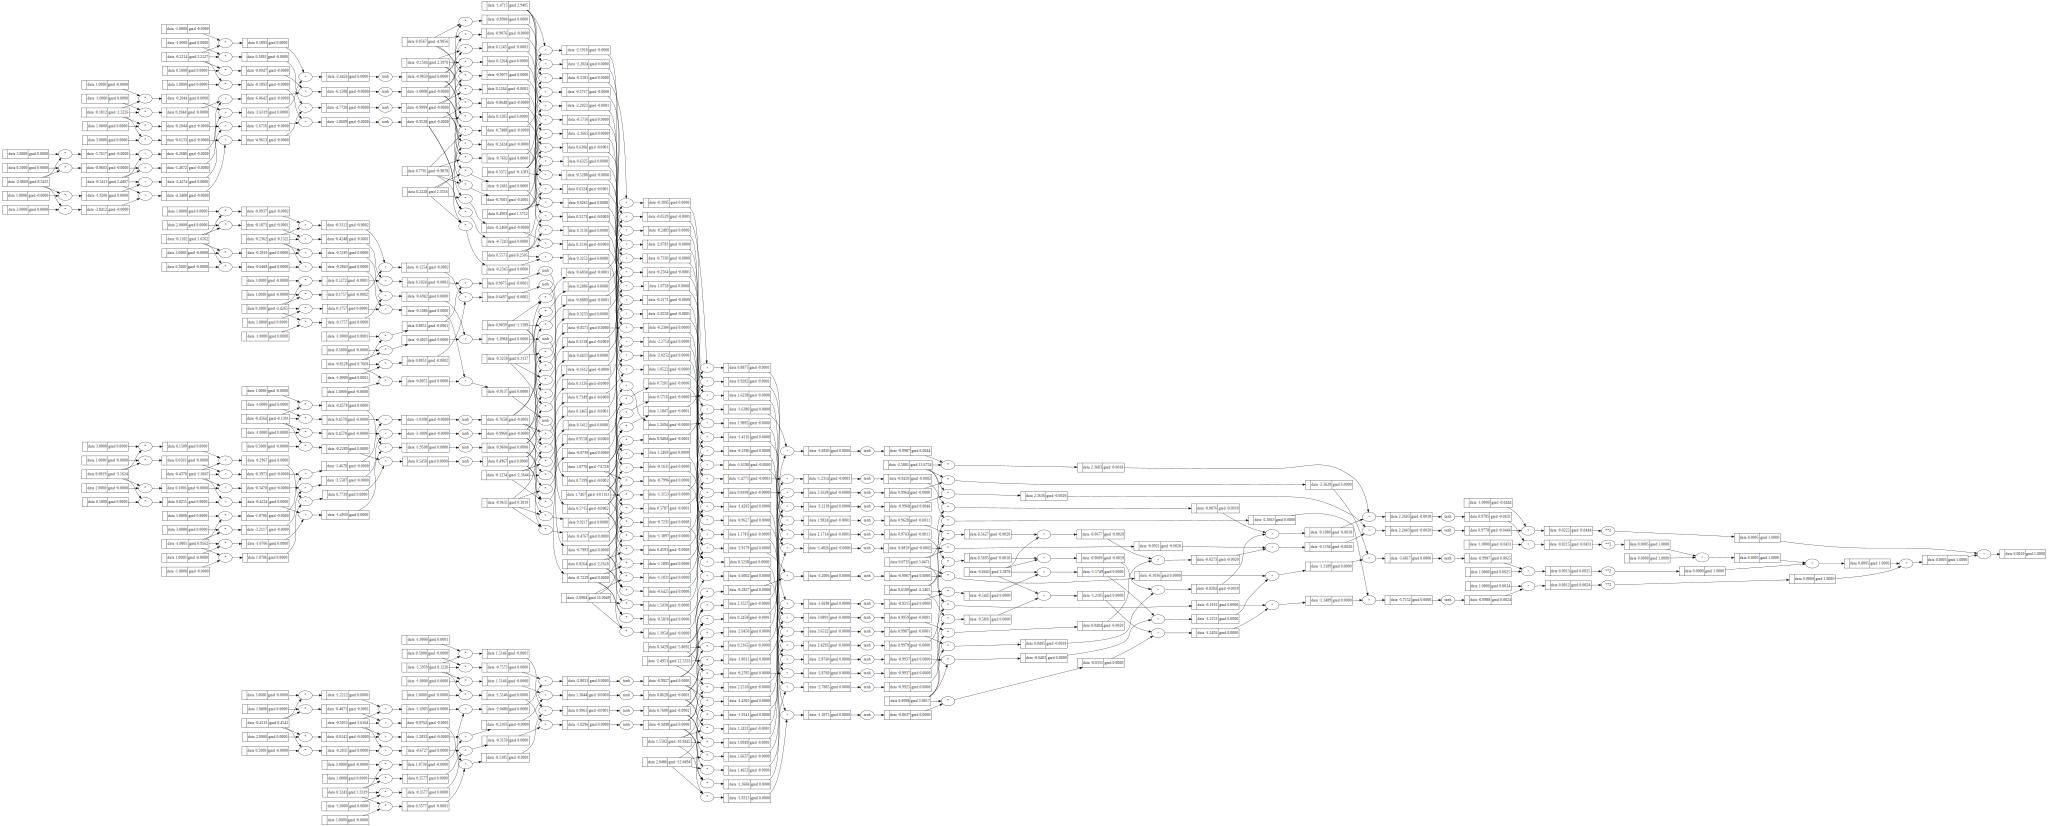

In [397]:
draw_dot(loss)